In [1]:
using ITensors
using RandomMeas
using ProgressBars
using MAT
# TODO: add MAT to the required dependencies

Precompiling RandomMeas
  ✓ RandomMeas
  1 dependency successfully precompiled in 4 seconds. 241 already precompiled.


In [2]:
## parameters 
N = 10
times = [0,1,2,3,4,5] ## quench time between 0 to 5 ms
ntimes = length(times)
ξ = siteinds("Qubit", N);
nu, NM = 500,150
data = zeros(Int8,ntimes,nu,NM,N);
n = 6
NAmax = 8;

In [3]:
#Load theory state
ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NAmax,n-1)
S = zeros(Float64,ntimes,NAmax,n-1)
SvN = zeros(Float64,ntimes,NAmax)
ITensors.disable_warn_order()

for s in 1:ntimes
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(times[s])*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    push!(ρ,ITensor(qstate,vcat(ξ',ξ)))
    for NA in 1:NAmax
        A = collect(1:NA)
        ρA = copy(ρ[s])
        for i in 1:N
            if !(i in A)
                ρA *= δ(ξ[i],ξ[i]')
            end
        end
        for nt in 2:n
            p[s,NA,nt-1] = real(trace(power(ρA,nt),ξ[1:NA]))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
        D, = eigen(ρA,ξ[1:NA]',ξ[1:NA];ishermitian=true)
        for k in 1:2^NA
            if D[k,k]>1e-12
                SvN[s,NA] -= D[k,k]*log2(D[k,k])
            end
        end
    end
end

In [4]:
u = Vector{Vector{Vector{ITensor}}}()
for s in 1:ntimes
    vars = matread("BrydgesScience2019data/unitaries_10_T_" * string(times[s]) * "_flr_1.mat")
    raw_measurements = vars["qstates" * string(times[s])]

    for r in 1:nu
        for m in 1:NM
            data[s,r,m,:] = reverse(digits(floor(Int,raw_measurements[r,m]), base=2, pad=N) .+ 1)
        end
    end    
    
    ut = Vector{Vector{ITensor}}()
    for r in 1:nu
        push!(ut,[ITensor(vars["unitaries"][r,i],ξ[i]',ξ[i]) for i in 1:N])
    end
    push!(u,ut)
end

In [5]:
#Purity from Hamming and shadow formulas
p_hamming = zeros(Float64,ntimes,NAmax)
p_shadow = zeros(Float64,ntimes,NAmax)
for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        p_hamming[s,NA] = get_purity_hamming(data[s,:,:,1:NA],ξ[1:NA])
        p_shadow[s,NA] = get_purity_shadows(data[s,:,:,1:NA],uA,ξ[1:NA])
    end
end

0.0%┣                                                ┫ 0/6 [00:01<00:-7, -1s/it]
16.7%┣███████▏                                   ┫ 1/6 [00:57<Inf:Inf, InfGs/it]
33.3%┣███████████████▊                               ┫ 2/6 [01:02<04:09, 62s/it]
50.0%┣███████████████████████▌                       ┫ 3/6 [01:07<01:41, 34s/it]
66.7%┣███████████████████████████████▍               ┫ 4/6 [01:12<00:48, 24s/it]
83.3%┣███████████████████████████████████████▏       ┫ 5/6 [01:17<00:19, 19s/it]
100.0%┣██████████████████████████████████████████████┫ 6/6 [01:22<00:00, 16s/it]
100.0%┣██████████████████████████████████████████████┫ 6/6 [01:22<00:00, 16s/it]


In [8]:
#Tr(rho^n) and Renyis from batch shadows
p_bshadow = zeros(Float64,ntimes,NAmax,n-1)
S_bshadow = zeros(Float64,ntimes,NAmax,n-1)
for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        ξA = ξ[1:NA]
        @show NA
        @time ρs = get_batch_shadows(data[s,:,:,1:NA],ξA,uA,n)
        @time p_bshadow[s,NA,:] = get_moments(ρs, ξA, n)
        @time for nt in 2:n
            S_bshadow[s,NA,nt-1]= log2(p_bshadow[s,NA,nt-1])/(1-nt)
        end
    end
end

NA = 1
  0.011749 seconds (183.32 k allocations: 26.056 MiB)


0.0%┣                                                ┫ 0/6 [00:00<00:00, -0s/it]


  0.103804 seconds (485.13 k allocations: 75.607 MiB, 82.15% compilation time)
  0.000012 seconds (29 allocations: 816 bytes)
NA = 2
  0.034641 seconds (393.12 k allocations: 85.709 MiB, 19.44% compilation time)
  0.072401 seconds (500.63 k allocations: 132.006 MiB, 57.14% gc time)
  0.000011 seconds (29 allocations: 816 bytes)
NA = 3
  0.126888 seconds (600.26 k allocations: 149.242 MiB, 56.37% gc time, 8.24% compilation time)
  0.048610 seconds (594.23 k allocations: 211.557 MiB)
  0.000008 seconds (29 allocations: 816 bytes)
NA = 4
  0.120750 seconds (927.45 k allocations: 252.274 MiB, 23.05% gc time, 12.72% compilation time)
  0.106113 seconds (691.73 k allocations: 323.780 MiB, 22.95% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 5
  0.172831 seconds (1.25 M allocations: 416.714 MiB, 12.82% gc time, 12.89% compilation time)
  0.180896 seconds (793.13 k allocations: 554.419 MiB, 12.85% gc time)
  0.000011 seconds (29 allocations: 816 bytes)
NA = 6
  0.309919 seconds 

16.7%┣███████▏                                   ┫ 1/6 [00:12<Inf:Inf, InfGs/it]


  0.041946 seconds (500.63 k allocations: 132.006 MiB, 23.43% gc time)
  0.000030 seconds (29 allocations: 816 bytes)
NA = 3
  0.056315 seconds (601.88 k allocations: 149.259 MiB, 19.75% gc time)
  0.063330 seconds (594.23 k allocations: 211.557 MiB, 16.83% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 4
  0.104048 seconds (956.16 k allocations: 253.264 MiB, 17.96% gc time)
  0.097903 seconds (691.73 k allocations: 323.780 MiB, 20.84% gc time)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 5
  0.150352 seconds (1.33 M allocations: 418.917 MiB, 10.15% gc time)
  0.194400 seconds (793.13 k allocations: 554.419 MiB, 16.89% gc time)
  0.000008 seconds (29 allocations: 816 bytes)
NA = 6
  0.282659 seconds (1.83 M allocations: 803.675 MiB, 8.65% gc time)
  0.372609 seconds (912.11 k allocations: 1.218 GiB, 13.18% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 7
  0.624201 seconds (2.39 M allocations: 1.959 GiB, 7.66% gc time)
  1.111512 seconds (1.03 M alloc

33.3%┣███████████████▊                               ┫ 2/6 [00:22<01:30, 22s/it]


  0.032969 seconds (500.63 k allocations: 132.006 MiB)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 3
  0.053451 seconds (602.10 k allocations: 149.266 MiB, 20.90% gc time)
  0.066194 seconds (594.23 k allocations: 211.557 MiB, 18.64% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 4
  0.103282 seconds (962.35 k allocations: 253.428 MiB, 20.02% gc time)
  0.091418 seconds (691.73 k allocations: 323.780 MiB, 13.15% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 5
  0.169548 seconds (1.36 M allocations: 419.698 MiB, 16.65% gc time)
  0.184158 seconds (793.13 k allocations: 554.419 MiB, 10.03% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 6
  0.290715 seconds (1.90 M allocations: 808.118 MiB, 11.65% gc time)
  0.337417 seconds (912.11 k allocations: 1.218 GiB, 12.34% gc time)
  0.000005 seconds (29 allocations: 816 bytes)
NA = 7
  0.640108 seconds (2.51 M allocations: 1.962 GiB, 7.96% gc time)
  1.178885 seconds (1.03 M allocations: 3.688 G

50.0%┣███████████████████████▌                       ┫ 3/6 [00:33<00:50, 17s/it]


  0.033942 seconds (500.63 k allocations: 132.006 MiB)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 3
  0.062017 seconds (602.14 k allocations: 149.268 MiB, 24.27% gc time)
  0.066051 seconds (594.23 k allocations: 211.557 MiB, 22.43% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 4
  0.094870 seconds (964.95 k allocations: 253.496 MiB, 13.02% gc time)
  0.105997 seconds (691.73 k allocations: 323.780 MiB, 25.24% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 5
  0.161405 seconds (1.38 M allocations: 420.119 MiB, 12.94% gc time)
  0.188257 seconds (793.13 k allocations: 554.419 MiB, 11.72% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 6
  0.305333 seconds (1.95 M allocations: 809.895 MiB, 11.56% gc time)
  0.316353 seconds (912.11 k allocations: 1.218 GiB, 13.12% gc time)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 7
  0.644996 seconds (2.60 M allocations: 1.965 GiB, 7.37% gc time)
  1.156254 seconds (1.03 M allocations: 3.688 G

66.7%┣███████████████████████████████▍               ┫ 4/6 [00:44<00:29, 15s/it]


  0.052263 seconds (500.63 k allocations: 132.006 MiB, 31.84% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 3
  0.047256 seconds (602.14 k allocations: 149.268 MiB)
  0.070507 seconds (594.23 k allocations: 211.557 MiB, 25.47% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 4
  0.100622 seconds (966.12 k allocations: 253.527 MiB, 15.47% gc time)
  0.110266 seconds (691.73 k allocations: 323.780 MiB, 27.70% gc time)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 5
  0.155505 seconds (1.39 M allocations: 420.329 MiB, 7.38% gc time)
  0.201841 seconds (793.13 k allocations: 554.419 MiB, 19.41% gc time)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 6
  0.289949 seconds (1.97 M allocations: 810.502 MiB, 8.77% gc time)
  0.324259 seconds (912.11 k allocations: 1.218 GiB, 14.42% gc time)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 7
  0.707935 seconds (2.63 M allocations: 1.966 GiB, 10.40% gc time)
  1.048036 seconds (1.03 M allocations: 3.688 Gi

83.3%┣███████████████████████████████████████▏       ┫ 5/6 [00:54<00:14, 14s/it]


  0.035147 seconds (500.63 k allocations: 132.006 MiB)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 3
  0.062944 seconds (602.15 k allocations: 149.268 MiB, 29.83% gc time)
  0.069978 seconds (594.23 k allocations: 211.557 MiB, 26.95% gc time)
  0.000007 seconds (29 allocations: 816 bytes)
NA = 4
  0.101975 seconds (966.51 k allocations: 253.537 MiB, 15.48% gc time)
  0.091577 seconds (691.73 k allocations: 323.780 MiB, 15.72% gc time)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 5
  0.170220 seconds (1.39 M allocations: 420.504 MiB, 16.12% gc time)
  0.192630 seconds (793.13 k allocations: 554.419 MiB, 13.72% gc time)
  0.000006 seconds (29 allocations: 816 bytes)
NA = 6
  0.302677 seconds (1.99 M allocations: 811.139 MiB, 10.56% gc time)
  0.334482 seconds (912.11 k allocations: 1.218 GiB, 13.59% gc time)
  0.000008 seconds (29 allocations: 816 bytes)
NA = 7
  0.716229 seconds (2.67 M allocations: 1.967 GiB, 9.43% gc time)
  1.168703 seconds (1.03 M allocations: 3.688 G

100.0%┣██████████████████████████████████████████████┫ 6/6 [01:06<00:00, 13s/it]
100.0%┣██████████████████████████████████████████████┫ 6/6 [01:06<00:00, 13s/it]


In [9]:
#Tr(rho^n) and Renyis from batch shadows
p_bshadow_jk = zeros(Float64,nu,ntimes,NAmax,n-1)
S_bshadow_jk = zeros(Float64,nu,ntimes,NAmax,n-1)

function find_group(vector_of_vectors, i)
    for (index, vec) in pairs(vector_of_vectors)
        if i in vec
            return index, length(vec)
        end
    end
    return nothing, 0  # Return nothing and size 0 if the integer is not found
end

function get_batches(data::Array{Int8}, n::Int64)
    batches = Vector{Vector{Int}}()
    nu = size(data, 1)
    nu_n = nu ÷ n
    for t in 1:n
        push!(batches,collect(1+(t-1)*nu_n:t*nu_n))
    end
    return batches
end

for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
            @show s,NA
            uA = [ut[1:NA] for ut in u[s]]
            ξA = ξ[1:NA]
            ρs = get_batch_shadows(data[s,:,:,1:NA],ξA,uA,n)
            batches = get_batches(data[s,:,:,1:NA],n) # A vector of vectors, specifying which shadow in which batch 
            for r in 1:batches[end][end]
                ρr = get_batch_shadows(reshape(data[s,r,:,1:NA],1,NM,NA),ξA,[uA[r]],1) # get the shadow of r
                batch,batch_size = find_group(batches,r) # find the batch of shadow r
                ρs_r = copy(ρs) 
                ρs_r[batch] = ((ρs_r[batch]*batch_size)-ρr[1])/(batch_size-1) # substract shadow r from the correct batch shadow
                p_bshadow_jk[r,s,NA,:] = get_moments(ρs_r, ξA, n) # do the estimation of shadow r removed
                for nt in 2:n
                    S_bshadow_jk[r,s,NA,nt-1]= log2(p_bshadow_jk[r,s,NA,nt-1])/(1-nt)
                end
            end
    end
end

(s, NA) = (1, 1)
(s, NA) = 

0.0%┣                                                ┫ 0/6 [00:00<00:00, -0s/it]


(1, 2)
(s, NA) = (1, 3)
(s, NA) = (1, 4)
(s, NA) = (1, 5)
(s, NA) = (1, 6)
(s, NA) = (1, 7)
(s, NA) = (1, 8)
(s, NA) = (2, 1)
(s, NA) = 

16.7%┣██████▊                                 ┫ 1/6 [01:05:45<Inf:Inf, InfGs/it]


(2, 2)
(s, NA) = (2, 3)
(s, NA) = (2, 4)
(s, NA) = (2, 5)
(s, NA) = (2, 6)
(s, NA) = (2, 7)
(s, NA) = (2, 8)
(s, NA) = (3, 1)
(s, NA) = 

33.3%┣█████████████                          ┫ 2/6 [02:12:39<08:50:37, 8.0ks/it]


(3, 2)
(s, NA) = (3, 3)
(s, NA) = (3, 4)
(s, NA) = (3, 5)
(s, NA) = (3, 6)
(s, NA) = (3, 7)
(s, NA) = (3, 8)
(s, NA) = (4, 1)
(s, NA) = 

50.0%┣███████████████████▌                   ┫ 3/6 [03:18:35<04:57:52, 6.0ks/it]


(4, 2)
(s, NA) = (4, 3)
(s, NA) = (4, 4)
(s, NA) = (4, 5)
(s, NA) = (4, 6)
(s, NA) = (4, 7)
(s, NA) = (4, 8)
(s, NA) = (5, 1)
(s, NA) = 

66.7%┣██████████████████████████             ┫ 4/6 [04:24:31<02:56:21, 5.3ks/it]


(5, 2)
(s, NA) = (5, 3)
(s, NA) = (5, 4)
(s, NA) = (5, 5)
(s, NA) = (5, 6)
(s, NA) = (5, 7)
(s, NA) = (5, 8)
(s, NA) = (6, 1)
(s, NA) = 

83.3%┣████████████████████████████████▌      ┫ 5/6 [05:29:39<01:22:25, 4.9ks/it]


(6, 2)
(s, NA) = (6, 3)
(s, NA) = (6, 4)
(s, NA) = (6, 5)
(s, NA) = (6, 6)
(s, NA) = (6, 7)
(s, NA) = (6, 8)


100.0%┣█████████████████████████████████████████┫ 6/6 [06:35:26<00:00, 4.7ks/it]
100.0%┣█████████████████████████████████████████┫ 6/6 [06:35:26<00:00, 4.7ks/it]


In [10]:
using NPZ

npzwrite("jk_brydges.npz",Dict("p_bshadow_jk"=>p_bshadow_jk,"S_bshadow_jk"=>S_bshadow_jk))



In [11]:
vars = npzread("jk_brydges.npz")
S_bshadow_jk = vars["S_bshadow_jk"]
p_bshadow_jk = vars["p_bshadow_jk"]

500×6×8×5 Array{Float64, 4}:
[:, :, 1, 1] =
 0.970829  0.7418    0.514012  0.503263  0.500904  0.518022
 0.966756  0.740083  0.513935  0.503224  0.500873  0.517616
 0.972569  0.742421  0.514016  0.503301  0.500908  0.517997
 0.971051  0.741787  0.513968  0.503251  0.500917  0.51795
 0.972404  0.742339  0.514053  0.503251  0.500925  0.518024
 0.969513  0.740364  0.51401   0.50324   0.500921  0.51783
 0.970075  0.741559  0.513952  0.50318   0.500915  0.518033
 0.972208  0.742233  0.514021  0.503242  0.500919  0.518042
 0.972118  0.742254  0.514044  0.503256  0.500928  0.518037
 0.968591  0.740809  0.513906  0.503183  0.500926  0.517812
 ⋮                                                 ⋮
 0.968608  0.740527  0.51388   0.50322   0.500905  0.517959
 0.972558  0.742399  0.514028  0.503259  0.500927  0.518064
 0.967965  0.740655  0.513977  0.503182  0.500907  0.517731
 0.967866  0.740266  0.513971  0.503223  0.500949  0.517904
 0.972861  0.742646  0.514031  0.503248  0.50092   0.518033
 0.97

In [12]:
using Statistics
size(p_bshadow_jk)
p_bshadow_jk_mean = mean(p_bshadow_jk[1:498,:,:,:],dims=1)
p_bshadow_jk_mean = p_bshadow_jk_mean[1,:,:,:]
S_bshadow_jk_mean = mean(S_bshadow_jk[1:498,:,:,:],dims=1)
S_bshadow_jk_mean = S_bshadow_jk_mean[1,:,:,:]

@show size(p_bshadow_jk_mean) size(p_bshadow)
p_bshadow_jk_bias = 497 * (p_bshadow_jk_mean - p_bshadow)
S_bshadow_jk_bias = 497 * (S_bshadow_jk_mean - S_bshadow)

@show maximum(abs.(p_bshadow_jk_bias)) 
@show maximum(abs.(S_bshadow_jk_bias)) 

p_bshadow_jk_var =497*var(p_bshadow_jk[1:498,:,:,:],dims=1,corrected=false)
p_bshadow_jk_var=p_bshadow_jk_var[1,:,:,:]
S_bshadow_jk_var =497*var(S_bshadow_jk[1:498,:,:,:],dims=1,corrected=false)
S_bshadow_jk_var=S_bshadow_jk_var[1,:,:,:]
@show maximum((p_bshadow_jk_var)) 
@show maximum((S_bshadow_jk_var)) 


size(p_bshadow_jk_mean) = (6, 8, 5)
size(p_bshadow) = (6, 8, 5)
maximum(abs.(p_bshadow_jk_bias)) = 8.276712648580542e-13
maximum(abs.(S_bshadow_jk_bias)) = 0.2906022838051223
maximum(p_bshadow_jk_var) = 0.0351495625405987
maximum(S_bshadow_jk_var) = 0.838615945921627


0.838615945921627

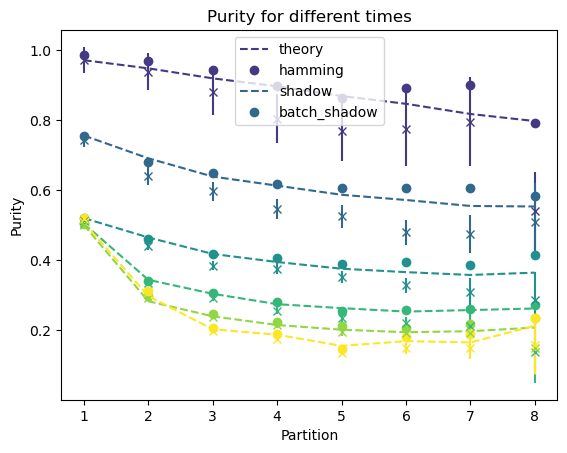

In [14]:
using PyPlot

clf()

cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NAmax,p[s,:,1],"--",color=cm(s/ntimes))
    plot(1:NAmax,p_hamming[s,:],"o",color=cm(s/ntimes))
    #plot(1:NAmax,p_shadow[s,:],"x",color=cm(s/ntimes))
    #plot(1:NAmax,p_bshadow[s,:,1],"*",color=cm(s/ntimes))
    errorbar(1:NAmax,p_bshadow[s,:,1]-p_bshadow_jk_bias[s,:,1],yerr=sqrt.(p_bshadow_jk_var[s,:,1]),fmt="x",color=cm(s/ntimes))

end
#yscale("log")
xlabel("Partition")
ylabel("Purity")
legend(["theory","hamming","shadow","batch_shadow"])
title("Purity for different times")

gcf()

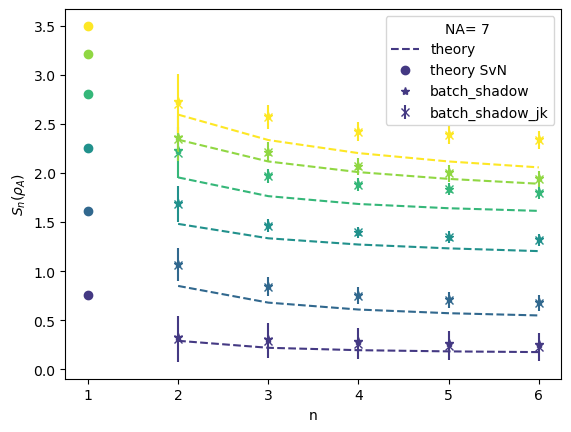

In [16]:
using PyPlot

clf()

co = ["blue","red","green","magenta","orange","black"]
NA = 7

for s in 1:1
    plot(2:n,S[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot([1],[SvN[s,NA]],"o",color=cm(s/ntimes),label="theory SvN")
    plot(2:n,S_bshadow[s,NA,:],"*",color=cm(s/ntimes),label="batch_shadow")
    errorbar(2:n,S_bshadow[s,NA,:]-S_bshadow_jk_bias[s,NA,:],yerr=sqrt.(S_bshadow_jk_var[s,NA,:]),fmt="x",color=cm(s/ntimes),label="batch_shadow_jk")
end
for s in 2:ntimes
    plot(2:n,S[s,NA,:],"--",color=cm(s/ntimes))
    plot([1],[SvN[s,NA]],"o",color=cm(s/ntimes))
    plot(2:n,S_bshadow[s,NA,:],"*",color=cm(s/ntimes))
    errorbar(2:n,S_bshadow[s,NA,:]-S_bshadow_jk_bias[s,NA,:],yerr=sqrt.(S_bshadow_jk_var[s,NA,:]),fmt="x",color=cm(s/ntimes))
end
#yscale("log")
xlabel("n")
ylabel(L"S_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()

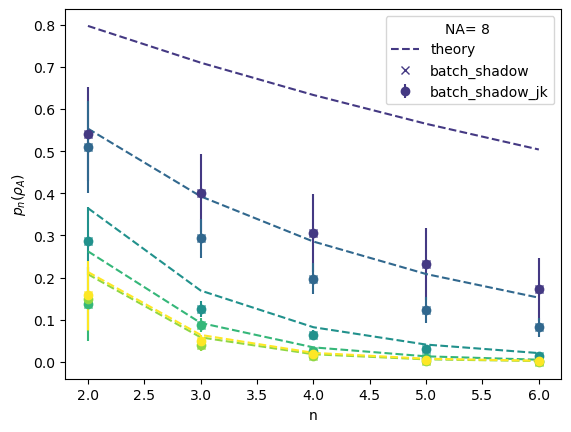

In [17]:
using PyPlot

clf()

co = ["blue","red","green","magenta","orange","black"]
NA =8
for s in 1:1
    plot(2:n,p[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot(2:n,p_bshadow[s,NA,:],"x",color=cm(s/ntimes),label="batch_shadow")
    errorbar(2:n,p_bshadow[s,NA,:]-p_bshadow_jk_bias[s,NA,:],yerr=sqrt.(p_bshadow_jk_var[s,NA,:]),fmt="o",color=cm(s/ntimes),label="batch_shadow_jk")
end
for s in 2:ntimes
    plot(2:n,p[s,NA,:],"--",color=cm(s/ntimes))
    plot(2:n,p_bshadow[s,NA,:],"x",color=cm(s/ntimes))
    errorbar(2:n,p_bshadow[s,NA,:]-p_bshadow_jk_bias[s,NA,:],yerr=sqrt.(p_bshadow_jk_var[s,NA,:]),fmt="o",color=cm(s/ntimes))
end
#yscale("log")
xlabel("n")
ylabel(L"p_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()
